In [ ]:
!pip install gym
!pip install gym[atari]
!pip install stable-baselines3[extra]
!pip install torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-p

CartPole 环境的 DQN **实现（全连接网络架构**

episode: 0/1000, score: 29, e: 1.0
episode: 1/1000, score: 9, e: 1.0
episode: 2/1000, score: 53, e: 0.86
episode: 3/1000, score: 16, e: 0.8
episode: 4/1000, score: 10, e: 0.76
episode: 5/1000, score: 13, e: 0.71
episode: 6/1000, score: 22, e: 0.64
episode: 7/1000, score: 10, e: 0.61
episode: 8/1000, score: 14, e: 0.56
episode: 9/1000, score: 17, e: 0.52
episode: 10/1000, score: 8, e: 0.5
episode: 11/1000, score: 7, e: 0.48
episode: 12/1000, score: 8, e: 0.46
episode: 13/1000, score: 10, e: 0.44
episode: 14/1000, score: 12, e: 0.41
episode: 15/1000, score: 16, e: 0.38
episode: 16/1000, score: 15, e: 0.35
episode: 17/1000, score: 11, e: 0.34
episode: 18/1000, score: 11, e: 0.32
episode: 19/1000, score: 10, e: 0.3
episode: 20/1000, score: 9, e: 0.29
episode: 21/1000, score: 11, e: 0.27
episode: 22/1000, score: 8, e: 0.26
episode: 23/1000, score: 9, e: 0.25
episode: 24/1000, score: 10, e: 0.24
episode: 25/1000, score: 9, e: 0.23
episode: 26/1000, score: 8, e: 0.22
episode: 27/1000, score: 

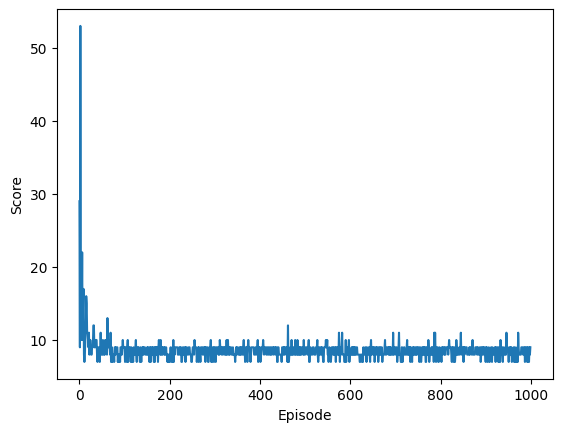

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import os
import matplotlib.pyplot as plt

# 创建环境
env = gym.make('CartPole-v1')

# 超参数
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
batch_size = 64
n_episodes = 1000
output_dir = 'model_output/cartpole/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # 全连接神经网络模型
        model = nn.Sequential(
            nn.Linear(self.state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.action_size)
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state)
        act_values = self.model(state)
        return np.argmax(act_values.detach().numpy())  # 返回动作值

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state = torch.FloatTensor(next_state)
                target = reward + self.gamma * torch.max(self.model(next_state)).item()
            state = torch.FloatTensor(state)
            target_f = self.model(state)
            target_f = target_f.detach().numpy()
            target_f[0][action] = target
            target_f = torch.FloatTensor(target_f)
            self.model.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
            optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

agent = DQNAgent(state_size, action_size)

scores = []
done = False
for e in range(n_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(500):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            scores.append(time)
            print(f"episode: {e}/{n_episodes}, score: {time}, e: {agent.epsilon:.2}")
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    if e % 50 == 0:
        torch.save(agent.model.state_dict(), output_dir + "weights_" + '{:04d}'.format(e) + ".hdf5")

# 绘制分数曲线
plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()


In [ ]:
!pip install gymnasium
!pip install stable-baselines3[extra]
!pip install opencv-python


Breakout 环境的 DQN **实现（卷积神经网络架构）**

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import cv2
import os
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo

# 创建环境
env = gym.make('Breakout-v0')

# 超参数
state_size = (84, 84, 4)
action_size = env.action_space.n
batch_size = 32
n_episodes = 100
output_dir = 'model_output/breakout/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

class DQNAgent:
    def __init__(self, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.00025
        self.model = self._build_model()

    def _build_model(self):
        # 卷积神经网络模型
        model = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, 512),
            nn.ReLU(),
            nn.Linear(512, self.action_size),
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return np.argmax(act_values.detach().numpy())

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state = torch.FloatTensor(next_state).unsqueeze(0)
                target = reward + self.gamma * torch.max(self.model(next_state)).item()
            state = torch.FloatTensor(state).unsqueeze(0)
            target_f = self.model(state)
            target_f = target_f.detach().numpy()
            target_f[0][action] = target
            target_f = torch.FloatTensor(target_f)
            self.model.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
            optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (84, 84))
    return frame

agent = DQNAgent(action_size)

scores = []
for e in range(n_episodes):
    state, _ = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=0)
    for time in range(10000):
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state = np.append(state[1:, :, :], np.expand_dims(next_state, 0), axis=0)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            scores.append(time)
            print(f"episode: {e}/{n_episodes}, score: {time}, e: {agent.epsilon:.2}")
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    if e % 50 == 0:
        torch.save(agent.model.state_dict(), output_dir + "weights_" + '{:04d}'.format(e) + ".hdf5")

# 绘制分数曲线
plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

# 运行训练好的智能体并保存视频
def run_trained_agent(env_name, agent, video_dir):
    env = gym.make(env_name)
    env = RecordVideo(env, video_dir, episode_trigger=lambda x: True)
    state, _ = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=0)
    done = False
    total_reward = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state = np.append(state[1:, :, :], np.expand_dims(next_state, 0), axis=0)
        state = next_state
        total_reward += reward
    env.close()
    return total_reward

video_dir = './videos/breakout'
run_trained_agent('Breakout-v0', agent, video_dir)


episode: 0/100, score: 239, e: 0.35
